# Implementation of "Multi-style Generative Network for Real-time Transfer"

### 1. Imports

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time

/home/dikatok/miniconda3/envs/deeplearning/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 2. Configuration

In [2]:
STYLE_IMG = "../test_images/styles/stars2.jpg"
CONTENT_IMG = "../test_images/contents/venice-boat.jpg"

STYLE_DIR = "../styles/"
CONTENT_DIR = "../contents/"
VGG_WEIGHT = "../vgg16_weights.npz"
LOG_DIR = "./logs"
MODEL_DIR = "./models"
CKPT_DIR = "./ckpts"

NUM_EPOCHS = 4
LEARNING_RATE = 1e-3
CONTENT_BATCH_SIZE = 4
STYLE_BATCH_SIZE = 1
LOG_ITER = 100
SAMPLE_ITER = 100
STYLE_SIZE = 256
CONTENT_SIZE = 256

CONTENT_LOSS_WEIGHT = 1
STYLE_LOSS_WEIGHT = 5

### 3. VGG

In [3]:
def vgg16(x, weights):
    # substract imagenet mean
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='imagenet_mean')
    x = x - mean
    
    with tf.variable_scope("vgg16", reuse=tf.AUTO_REUSE):
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_1_W"]), trainable=False, name='conv1_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_1_b"]), trainable=False, name='conv1_1_b')
            conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_1 = tf.nn.bias_add(conv1_1, biases)
            conv1_1 = tf.nn.relu(conv1_1, name=scope)

        with tf.name_scope('conv1_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_2_W"]), trainable=False, name='conv1_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_2_b"]), trainable=False, name='conv1_2_b')
            conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_2 = tf.nn.bias_add(conv1_2, biases)
            conv1_2 = tf.nn.relu(conv1_2, name=scope)

        pool1 = tf.nn.avg_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
                               name='pool1')

        with tf.name_scope('conv2_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_1_W"]), trainable=False, name='conv2_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_1_b"]), trainable=False, name='conv2_1_b')
            conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_1 = tf.nn.bias_add(conv2_1, biases)
            conv2_1 = tf.nn.relu(conv2_1, name=scope)

        with tf.name_scope('conv2_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_2_W"]), trainable=False, name='conv2_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_2_b"]), trainable=False, name='conv2_2_b')
            conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_2 = tf.nn.bias_add(conv2_2, biases)
            conv2_2 = tf.nn.relu(conv2_2, name=scope)

        pool2 = tf.nn.avg_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool2')

        with tf.name_scope('conv3_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_1_W"]), trainable=False, name='conv3_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_1_b"]), trainable=False, name='conv3_1_b')
            conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_1 = tf.nn.bias_add(conv3_1, biases)
            conv3_1 = tf.nn.relu(conv3_1, name=scope)

        with tf.name_scope('conv3_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_2_W"]), trainable=False, name='conv3_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_2_b"]), trainable=False, name='conv3_2_b')
            conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_2 = tf.nn.bias_add(conv3_2, biases)
            conv3_2 = tf.nn.relu(conv3_2, name=scope)

        with tf.name_scope('conv3_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_3_W"]), trainable=False, name='conv3_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_3_b"]), trainable=False, name='conv3_3_b')
            conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_3 = tf.nn.bias_add(conv3_3, biases)
            conv3_3 = tf.nn.relu(conv3_3, name=scope)

        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool3')

        with tf.name_scope('conv4_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_1_W"]), trainable=False, name='conv4_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_1_b"]), trainable=False, name='conv4_1_b')
            conv4_1 = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_1 = tf.nn.bias_add(conv4_1, biases)
            conv4_1 = tf.nn.relu(conv4_1, name=scope)

        with tf.name_scope('conv4_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_2_W"]), trainable=False, name='conv4_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_2_b"]), trainable=False, name='conv4_2_b')
            conv4_2 = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_2 = tf.nn.bias_add(conv4_2, biases)
            conv4_2 = tf.nn.relu(conv4_2, name=scope)

        with tf.name_scope('conv4_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_3_W"]), trainable=False, name='conv4_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_3_b"]), trainable=False, name='conv4_3_b')
            conv4_3 = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_3 = tf.nn.bias_add(conv4_3, biases)
            conv4_3 = tf.nn.relu(conv4_3, name=scope)
            
    return conv1_2, conv2_2, conv3_3, conv4_3

### 4. Transformation net

The architecture of transformation network is similar to Johnson's architecture except bottleneck layer instead of normal residual block and the second and third convolution, upbottleneck instead of deconvolution, the addition of inspiration layer after the second downsampling bottleneck layer, and the introduction of siamese network (before residual blocks) to extract style gram matrices. Below is the diagram of the architecture and the bottleneck/upbottleneck layer.

<img style="margin: 0" src="./assets/architecture.png"/>

<img style="margin: 0" src="./assets/bottleneck.png"/>

Inspiration layer (later called CoMatch layer) in the architecture is derived from below formula which is the approximation of the loss minimization.

<img style="margin: 0" src="./assets/inspiration.png"/>

In [4]:
def instance_norm(x, name, epsilon=1e-5):
    with tf.variable_scope(name):
        gamma = tf.get_variable(shape=[x.shape[-1]], name="gamma")
        beta = tf.get_variable(shape=[x.shape[-1]], name="beta")
        mean, var = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        x = tf.nn.batch_normalization(x, mean, var, beta, gamma, epsilon, name="norm",)
    return x

def conv(x, name, filters, kernel_size, strides, norm=instance_norm, act=tf.nn.relu):
    padding = kernel_size//2
    with tf.variable_scope(name):
        x = tf.pad(x, paddings=[[0,0],[padding,padding],[padding,padding],[0,0]], mode="REFLECT")
        x = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, name="conv")
        if norm is not None: x = norm(x, name="norm")
        if act is not None: x = act(x, name="act")
    return x

def bottleneck_conv(x, name, filters, kernel_size, strides, norm=instance_norm, act=tf.nn.relu):
    padding = kernel_size//2
    with tf.variable_scope(name):
        if norm is not None: x = norm(x, name="norm")
        if act is not None: x = act(x, name="act")
        x = tf.pad(x, paddings=[[0,0],[padding,padding],[padding,padding],[0,0]], mode="REFLECT")
        x = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, name="conv")
    return x

def bottleneck(x, name, filters, strides=1):
    with tf.variable_scope(name):
        residual = conv(x, "residual", filters, kernel_size=1, strides=2, norm=None, act=None) if strides > 1 else x
        x = bottleneck_conv(x, "conv1", filters//4, kernel_size=1, strides=1)
        x = bottleneck_conv(x, "conv2", filters//4, kernel_size=3, strides=strides)
        x = bottleneck_conv(x, "conv3", filters, kernel_size=1, strides=1)
    return x + residual

def upbottleneck_conv(x, name, filters, kernel_size, strides, norm=instance_norm, act=tf.nn.relu):
    shape = x.shape.as_list()
    inferred_shape = tf.shape(x)
    w, h = shape[1] or inferred_shape[1], shape[2] or inferred_shape[2]
    x = tf.image.resize_images(x, size=[w * strides, h * strides])
    x = bottleneck_conv(x, name, filters, kernel_size, strides=1, norm=norm, act=act)
    return x
    
def upbottleneck(x, name, filters, strides=1):
    with tf.variable_scope(name):
        residual = upbottleneck_conv(x, "residual", filters, kernel_size=1, strides=2, norm=None, act=None) if strides > 1 else x
        x = upbottleneck_conv(x, "conv1", filters//4, kernel_size=1, strides=1)
        x = upbottleneck_conv(x, "conv2", filters//4, kernel_size=3, strides=strides)
        x = upbottleneck_conv(x, "conv3", filters, kernel_size=1, strides=1)
    return x + residual

def gram_matrix(x):
    batch_size, w, h, ch = x.shape.as_list()
    x = tf.reshape(x, [batch_size, w * h, ch])
    return tf.matmul(x, x, transpose_a=True) / (ch * w * h)
       
def inspiration(x, name, style_gram):
    shape = x.shape.as_list()
    inferred_shape = tf.shape(x)
    with tf.variable_scope(name):
        bs, w, h, ch = shape[0] or inferred_shape[0], shape[1] or inferred_shape[1], \
            shape[2] or inferred_shape[2], shape[3]
        weight = tf.get_variable(shape=[1,ch,ch], name="w")
        x = tf.reshape(x, shape=[-1, w * h, ch])
        x = x @ tf.tile(weight @ style_gram, [tf.shape(x)[0],1,1])
        x = tf.reshape(x, shape=[-1, w, h, ch])
    return x
        
def tnet(x, style_gram=None):    
    with tf.variable_scope("tnet", reuse=tf.AUTO_REUSE):
        conv1 = conv(x, "conv1", filters=64, kernel_size=9, strides=1)
        conv2 = bottleneck(conv1, "conv2", filters=128, strides=2)
        conv3 = bottleneck(conv2, "conv3", filters=512, strides=2)
        if style_gram is None:
            return gram_matrix(conv3)
        ins = inspiration(conv3, "inspiration", style_gram)
        res1 = bottleneck(ins, "res1", filters=512)
        res2 = bottleneck(res1, "res2", filters=512)
        res3 = bottleneck(res2, "res3", filters=512)
        res4 = bottleneck(res3, "res4", filters=512)
        res5 = bottleneck(res4, "res5", filters=512)
        up1 = upbottleneck(res5, "up1", filters=128, strides=2)
        up2 = upbottleneck(up1, "up2", filters=64, strides=2)
        conv4 = bottleneck_conv(up2, "conv4", filters=3, kernel_size=9, strides=1)
    return tf.clip_by_value(conv4, 0., 255.)

### 5. Loss definition

Below is the loss formula, we are also using total variation loss despite of using upsample convolutions.

<img style="margin: 0" src="./assets/loss.png"/>

In [5]:
def loss_fun(target_style_features, target_content_features, transferred, transferred_features, 
             style_loss_weight=STYLE_LOSS_WEIGHT, content_loss_weight=CONTENT_LOSS_WEIGHT):
    # using relu2_2 as content features
    content_loss = tf.reduce_mean(tf.subtract(transferred_features[1], target_content_features[1]) ** 2, 
                                  [1, 2, 3])  

    style_loss = 0
    for i in range(len(transferred_features)):
        gram_target = gram_matrix(target_style_features[i])
        gram_transferred = gram_matrix(transferred_features[i])
        style_loss += tf.reduce_mean(tf.subtract(gram_target, gram_transferred) ** 2, [1, 2])  
        
    return tf.reduce_mean(content_loss_weight * content_loss 
                          + style_loss_weight * style_loss 
                          + 1e-5 * tf.image.total_variation(transferred))

### 6. Content and style iterator

In [6]:
iterator = tf.keras.preprocessing.image.DirectoryIterator
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
content_iter = iterator(directory=CONTENT_DIR, batch_size=CONTENT_BATCH_SIZE, 
                        target_size=(CONTENT_SIZE,CONTENT_SIZE), image_data_generator=datagen, shuffle=True)
style_iter = iterator(directory=STYLE_DIR, batch_size=STYLE_BATCH_SIZE,
                      target_size=(STYLE_SIZE,STYLE_SIZE), image_data_generator=datagen)

Found 82783 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


### 7. Training with checkpoint on every epoch

In [7]:
if os.path.exists(CKPT_DIR):
    shutil.rmtree(CKPT_DIR)
    
vgg_weights = np.load(VGG_WEIGHT)

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

total_iteration = NUM_EPOCHS * content_iter.n // CONTENT_BATCH_SIZE

training_graph = tf.Graph()

with training_graph.as_default() as g, tf.Session(config=config, graph=training_graph) as sess:    
    style = tf.placeholder(name="style", dtype=tf.float32, 
                           shape=[STYLE_BATCH_SIZE,STYLE_SIZE,STYLE_SIZE,3])
    content = tf.placeholder(name="content", dtype=tf.float32, 
                             shape=[CONTENT_BATCH_SIZE,CONTENT_SIZE,CONTENT_SIZE,3])

    target_style_features = vgg16(style, vgg_weights)
    target_content_features = vgg16(content, vgg_weights)
    style_gram = tnet(style)
    transferred = tnet(content, style_gram)
    transferred_features = vgg16(transferred, vgg_weights)
    loss = loss_fun(target_style_features, target_content_features, transferred, transferred_features)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

    summary = tf.summary.FileWriter(graph=g, logdir=LOG_DIR)
    style_summary = tf.summary.image("style", style)
    content_summary = tf.summary.image("content", content)
    transferred_summary = tf.summary.image("transferred", transferred)
    image_summary = tf.summary.merge([style_summary, content_summary, transferred_summary])
    loss_summary = tf.summary.scalar("loss", loss)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(var_list=tf.trainable_variables())

    start = time.time()
    it = 0
    for i in range(NUM_EPOCHS):
        content_iter.reset()
        style_iter.reset()
        for c, _ in content_iter:
            it += 1
            
            if c.shape[0] < CONTENT_BATCH_SIZE:
                break
                 
            try:
                s, _ = style_iter.next()
            except StopIteration:
                style_iter.reset()
                s, _ = style_iter.next()
                    
            _, cur_loss, cur_loss_summary, cur_image_summary = sess.run([train_op, loss, loss_summary, 
                                                                         image_summary], 
                                                                        feed_dict={style: s, content: c})
            summary.add_summary(cur_loss_summary, it)

            if it % LOG_ITER == 0 or it == total_iteration:
                print("Iteration: [{it}/{num_iter}], loss: {loss}".format(it=it, num_iter=total_iteration,
                                                                          loss=cur_loss))
                
            if it % SAMPLE_ITER == 0 or it == total_iteration:
                summary.add_summary(cur_image_summary, it)
                
            summary.flush()
            
        ckpt_path = saver.save(sess, save_path=os.path.join(CKPT_DIR, "ckpt"), write_meta_graph=False, 
                               global_step=it)
        print("Checkpoint saved as: {ckpt_path}".format(ckpt_path=ckpt_path))
        
end = time.time()
print("Finished {num_iter} in {time} seconds".format(num_iter=total_iteration, time=end-start))

Iteration: [100/82783], loss: 2550166.0
Iteration: [200/82783], loss: 3260692.5
Iteration: [300/82783], loss: 1764478.0
Iteration: [400/82783], loss: 1433323.125
Iteration: [500/82783], loss: 2862248.0
Iteration: [600/82783], loss: 2105560.5
Iteration: [700/82783], loss: 2748305.5
Iteration: [800/82783], loss: 1586770.875
Iteration: [900/82783], loss: 854873.3125
Iteration: [1000/82783], loss: 532794.25
Iteration: [1100/82783], loss: 1794154.25
Iteration: [1200/82783], loss: 2711356.0
Iteration: [1300/82783], loss: 666761.25
Iteration: [1400/82783], loss: 1540316.25
Iteration: [1500/82783], loss: 1200446.625
Iteration: [1600/82783], loss: 1517967.625
Iteration: [1700/82783], loss: 2777326.5
Iteration: [1800/82783], loss: 1467528.875
Iteration: [1900/82783], loss: 900672.0625
Iteration: [2000/82783], loss: 757281.8125
Iteration: [2100/82783], loss: 2240058.0
Iteration: [2200/82783], loss: 666614.5
Iteration: [2300/82783], loss: 641108.0
Iteration: [2400/82783], loss: 3095388.0
Iteration

Iteration: [19200/82783], loss: 537694.1875
Iteration: [19300/82783], loss: 235811.265625
Iteration: [19400/82783], loss: 253098.515625
Iteration: [19500/82783], loss: 574054.625
Iteration: [19600/82783], loss: 373853.1875
Iteration: [19700/82783], loss: 303231.4375
Iteration: [19800/82783], loss: 365357.34375
Iteration: [19900/82783], loss: 393395.75
Iteration: [20000/82783], loss: 521074.34375
Iteration: [20100/82783], loss: 215026.625
Iteration: [20200/82783], loss: 248150.0625
Iteration: [20300/82783], loss: 182018.09375
Iteration: [20400/82783], loss: 153288.5
Iteration: [20500/82783], loss: 194958.828125
Iteration: [20600/82783], loss: 321459.4375
Checkpoint saved as: ./ckpts/ckpt-20696
Iteration: [20700/82783], loss: 304268.125
Iteration: [20800/82783], loss: 401682.84375
Iteration: [20900/82783], loss: 463410.21875
Iteration: [21000/82783], loss: 146574.375
Iteration: [21100/82783], loss: 433688.21875
Iteration: [21200/82783], loss: 639870.0
Iteration: [21300/82783], loss: 9647

Iteration: [37600/82783], loss: 110366.1328125
Iteration: [37700/82783], loss: 319809.96875
Iteration: [37800/82783], loss: 243871.0625
Iteration: [37900/82783], loss: 99444.5703125
Iteration: [38000/82783], loss: 294222.875
Iteration: [38100/82783], loss: 150167.78125
Iteration: [38200/82783], loss: 182966.25
Iteration: [38300/82783], loss: 110308.8125
Iteration: [38400/82783], loss: 250085.3125
Iteration: [38500/82783], loss: 190396.015625
Iteration: [38600/82783], loss: 321826.0625
Iteration: [38700/82783], loss: 2522281.5
Iteration: [38800/82783], loss: 524103.59375
Iteration: [38900/82783], loss: 430822.71875
Iteration: [39000/82783], loss: 121738.578125
Iteration: [39100/82783], loss: 135154.171875
Iteration: [39200/82783], loss: 254395.875
Iteration: [39300/82783], loss: 336336.625
Iteration: [39400/82783], loss: 356814.3125
Iteration: [39500/82783], loss: 278145.5
Iteration: [39600/82783], loss: 194728.265625
Iteration: [39700/82783], loss: 124406.8125
Iteration: [39800/82783],

Iteration: [56000/82783], loss: 134112.25
Iteration: [56100/82783], loss: 208170.21875
Iteration: [56200/82783], loss: 112696.046875
Iteration: [56300/82783], loss: 231425.09375
Iteration: [56400/82783], loss: 204490.96875
Iteration: [56500/82783], loss: 108911.7109375
Iteration: [56600/82783], loss: 229998.75
Iteration: [56700/82783], loss: 99890.140625
Iteration: [56800/82783], loss: 234424.78125
Iteration: [56900/82783], loss: 160435.765625
Iteration: [57000/82783], loss: 113214.4375
Iteration: [57100/82783], loss: 153261.078125
Iteration: [57200/82783], loss: 266554.4375
Iteration: [57300/82783], loss: 258497.4375
Iteration: [57400/82783], loss: 92536.09375
Iteration: [57500/82783], loss: 171054.25
Iteration: [57600/82783], loss: 186113.15625
Iteration: [57700/82783], loss: 215446.5
Iteration: [57800/82783], loss: 156130.375
Iteration: [57900/82783], loss: 150895.03125
Iteration: [58000/82783], loss: 115646.890625
Iteration: [58100/82783], loss: 97584.140625
Iteration: [58200/82783

KeyboardInterrupt: 

### 8. Create model based on latest checkpoint

In [7]:
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)

tf.reset_default_graph()

eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
exporter = tf.saved_model.builder.SavedModelBuilder(MODEL_DIR)
latest_ckpt = tf.train.latest_checkpoint(CKPT_DIR)

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:    
    style = tf.placeholder(name="style", dtype=tf.float32, shape=[1,STYLE_SIZE,STYLE_SIZE,3])
    inputs = tf.placeholder(name="inputs", dtype=tf.float32, shape=[None,None,None,3])
    
    style_gram_out = tf.identity(tnet(style), name="style_gram_out")
    style_gram_in = tf.placeholder(name="style_gram_in", dtype=tf.float32, shape=style_gram_out.shape)
    
    outputs = tf.identity(tnet(inputs, style_gram_in), name="outputs")
    
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt)
    
    exporter.add_meta_graph_and_variables(
        sess, 
        tags=[tf.saved_model.tag_constants.SERVING], 
        signature_def_map={
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            tf.saved_model.signature_def_utils.predict_signature_def(inputs={"inputs": inputs,
                                                                             "style": style,
                                                                             "style_gram_in": style_gram_in}, 
                                                                     outputs={"outputs": outputs,
                                                                              "style_gram_out": 
                                                                              style_gram_out})
        })
    exporter.save()

INFO:tensorflow:Restoring parameters from ./ckpts/ckpt-62088
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./models/saved_model.pb'


### 9. Test

INFO:tensorflow:Restoring parameters from b'./models/variables/variables'
Inference time: 1.2982230186462402 seconds


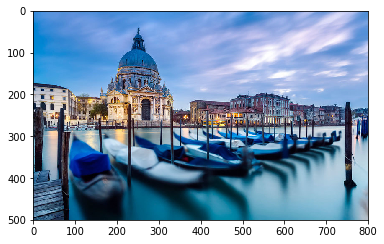

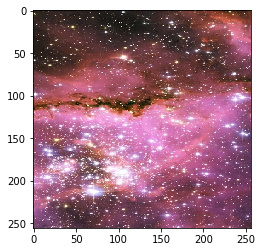

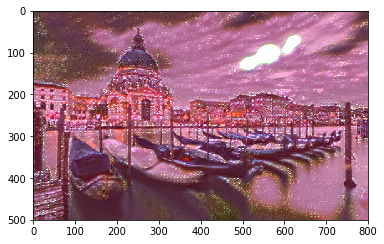

In [8]:
content_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(CONTENT_IMG))
style_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(STYLE_IMG, target_size=(STYLE_SIZE,STYLE_SIZE)))

tf.reset_default_graph()
eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:  
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], MODEL_DIR)
    inputs = g.get_tensor_by_name("inputs:0")
    style = g.get_tensor_by_name("style:0")
    style_gram_out = g.get_tensor_by_name("style_gram_out:0")
    style_gram_in = g.get_tensor_by_name("style_gram_in:0")
    outputs = g.get_tensor_by_name("outputs:0")    
    c, s = sess.run([tf.expand_dims(content_image, axis=0), tf.expand_dims(style_image, axis=0)])
    style_gram = sess.run(style_gram_out, feed_dict={style: s})
    start = time.time()
    result = sess.run(tf.squeeze(outputs), feed_dict={inputs: c, style_gram_in: style_gram})
    end = time.time()
    print("Inference time: {time} seconds".format(time=end-start))
    
plt.imshow(content_image / 255.)    
plt.show()

plt.imshow(style_image / 255.)    
plt.show()
    
plt.imshow(result / 255.)    
plt.show()

### 10. Commentary

As the name suggest, the power of this MSGnet is the ability to transfer multiple (trained) styles using a single network. There are key differences between Zhang's architecture and previous works, which are the introduction of inspiration/CoMatch layer and usage of bottleneck layer in downsampling, upsampling and residual blocks. Inspiration layer is used as an approximation of the loss minimization so that the network can learn multiple styles instead of just one. The result is actually quite satisfactory (despite my early stopping at 60k iteration). Another main advantage of this architecture is the size of the model is relatively small (< 10 mb) which is important for deployment in mobile devices.

### 11. Resources

1. Multi-style Generative Network for Real-time Transfer [https://arxiv.org/abs/1703.06953](https://arxiv.org/abs/1703.06953) [mxnet implementation](https://github.com/zhanghang1989/MXNet-Gluon-Style-Transfer)
2. Tensorflow vgg model and weights [http://www.cs.toronto.edu/~frossard/post/vgg16/](http://www.cs.toronto.edu/~frossard/post/vgg16/)
3. Using tensorflow saved_model [magenta](https://github.com/tensorflow/magenta/pull/796/commits/c3cb5ea8c40976be7bdc672e03639ab370a2399f), [stackoverflow](https://stackoverflow.com/questions/45705070/how-to-load-and-use-a-saved-model-on-tensorflow)